In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
%matplotlib inline

from prettytable import PrettyTable

In [ ]:
device = torch.device("cuda")

In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
SEED = 4222

In [ ]:
suicide_detection_df = pd.read_csv('/content/drive/MyDrive/Tumblr Vietnam/Tusat2.csv', header=0)
suicide_detection_df.drop(columns=['text'], axis=1, inplace=True)
suicide_detection_df = suicide_detection_df.rename(columns={"cleaned_text": "text"})
classes = {"suicide": 1, "non-suicide": 0}
suicide_detection_df = suicide_detection_df.replace({"class": classes})
suicide_detection_df = suicide_detection_df.dropna(subset=['text'])
suicide_detection_df.head()

,class,text
0,1,sex wife threaten suicide recently leave wife ...
1,0,weird not affect compliment come know girl fee...
2,0,finally hear bad year swear fucking god annoying
3,1,need help help cry hard
4,1,lose hello adam struggle year afraid past year...


In [ ]:
# Split dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(suicide_detection_df['text'], suicide_detection_df['class'],
                                                                    random_state=SEED,
                                                                    test_size=0.2,
                                                                    stratify=suicide_detection_df['class'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=SEED,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## Max Length and Number of vocab words in Train set

In [ ]:
max_length = max([len(s.split()) for s in train_text])
max_length

5850

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

vocab_size = len(tokenizer.word_index) + 1

## Padding

In [ ]:
def tokenize_and_encode(text, max_length=62):
    """Tokenize and encode sequences."""

    encoded_docs = tokenizer.texts_to_sequences(text)
    padded_sequence = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_sequence

tokens_train = tokenize_and_encode(train_text)
tokens_val = tokenize_and_encode(val_text)
tokens_test = tokenize_and_encode(test_text)

In [ ]:
train_data = TensorDataset(torch.from_numpy(tokens_train), torch.from_numpy(train_labels.to_numpy()))
val_data = TensorDataset(torch.from_numpy(tokens_val), torch.from_numpy(val_labels.to_numpy()))

train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

## Load Word Embedding

In [ ]:
```python
def load_embedding(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()[1:]
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

def get_weight_matrix(embedding, vocab, embedding_dim):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word, np.zeros(embedding_dim))
    return weight_matrix

def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim

raw_embedding_word2vec = load_embedding('/content/drive/MyDrive/Tumblr Vietnam/embedding_word2vec.txt')
embedding_vectors_word2vec = get_weight_matrix(raw_embedding_word2vec, tokenizer.word_index, 300)
embedding_vectors_word2vec = np.float32(embedding_vectors_word2vec)

raw_embedding_glove = load_embedding('/content/drive/MyDrive/Tumblr Vietnam/glove.twitter.27B.200d.txt')
embedding_vectors_glove = get_weight_matrix(raw_embedding_glove, tokenizer.word_index, 200)
embedding_vectors_glove = np.float32(embedding_vectors_glove)

for arr in embedding_vectors_glove:
    arr[np.isnan(arr)] = 0
```

In [ ]:
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout_rate, pre_trained=False, embedding_vectors=None):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        if pre_trained:
            self.embedding, num_embeddings, embedding_dim = create_emb_layer(embedding_vectors, True)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        return sig_out, hidden

    def init_hidden(self, batch_size):
        """
        Initializes hidden state.
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        return hidden


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
embedding_dim = 300
hidden_dim = 128
output_size = 1
n_layers = 2
dropout = 0.5

In [ ]:
criterion = nn.BCEWithLogitsLoss()

criterion = criterion.to(device)

In [ ]:
model1 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout)

print("No pre trained embedding weights")
print(model1)

print(f'Model 1 has {count_parameters(model1):,} trainable parameters')

No pre trained embedding weights
SentimentLSTM(
  (embedding): Embedding(37790, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model 1 has 11,689,385 trainable parameters


In [ ]:
model2 = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout,
                       pre_trained=True, embedding_vectors=embedding_vectors_word2vec)
model2.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_word2vec))

print("With Word2Vec pre trained embedding weights")
print(model2)

print(f'Model 2 has {count_parameters(model2):,} trainable parameters')

With Word2Vec pre trained embedding weights
SentimentLSTM(
  (embedding): Embedding(37790, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model 2 has 352,385 trainable parameters


In [ ]:
model3 = SentimentLSTM(vocab_size, output_size, 200, hidden_dim, n_layers, dropout,
                       pre_trained=True, embedding_vectors=embedding_vectors_glove)
model3.embedding.weight.data.copy_(torch.from_numpy(embedding_vectors_glove))

print("With gloVe pre trained embedding weights")
print(model3)

print(f'Model 3 has {count_parameters(model3):,} trainable parameters')

With gloVe pre trained embedding weights
SentimentLSTM(
  (embedding): Embedding(37790, 200)
  (lstm): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Model 3 has 301,185 trainable parameters


In [ ]:
def binary_accuracy(preds, labels):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    preds = torch.round(preds.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct = np.sum(correct)

    acc = num_correct/len(correct)

    return acc

In [ ]:

def train():
    model.train()

    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and step != 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        h = model.init_hidden(len(inputs))
        inputs, labels = inputs.cuda(), labels.cuda()
        h = tuple([each.data for each in h])

        model.zero_grad()
        preds, h = model(inputs, h)

        loss = criterion(preds.squeeze(), labels.float())
        total_loss += loss.item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        acc = binary_accuracy(preds, labels)
        total_accuracy += acc.item()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    avg_acc = total_accuracy / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds


In [ ]:
def evaluate():
    print("\nEvaluating...")

    model.eval()

    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and step != 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        inputs, labels = batch
        inputs = inputs.type(torch.LongTensor)

        val_h = model.init_hidden(len(inputs))
        inputs, labels = inputs.cuda(), labels.cuda()
        val_h = tuple([each.data for each in val_h])

        with torch.no_grad():
            preds, val_h = model(inputs, val_h)
            loss = criterion(preds.squeeze(), labels.float())
            total_loss += loss.item()

            acc = binary_accuracy(preds, labels)
            total_accuracy += acc.item()

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    avg_acc = total_accuracy / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_acc, total_preds


In [ ]:

optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

model = model1.to(device)

MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/Tumblr Vietnam/lstm_model_1_saved_weights.pt'

In [ ]:
best_valid_loss = float('inf')

model1_train_losses = []
model1_valid_losses = []

model1_train_accuracies = []
model1_valid_accuracies = []

for epoch in range(EPOCHS):
    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

    train_loss, train_acc, _ = train()
    valid_loss, valid_acc, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)

    model1_train_losses.append(train_loss)
    model1_valid_losses.append(valid_loss)

    model1_train_accuracies.append(train_acc)
    model1_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')



 Epoch 1 / 5
Batch    50 of 5,799.
Batch   100 of 5,799.
Batch   150 of 5,799.
Batch   200 of 5,799.
Batch   250 of 5,799.
Batch   300 of 5,799.
Batch   350 of 5,799.
Batch   400 of 5,799.
Batch   450 of 5,799.
Batch   500 of 5,799.
Batch   550 of 5,799.
Batch   600 of 5,799.
Batch   650 of 5,799.
Batch   700 of 5,799.
Batch   750 of 5,799.
Batch   800 of 5,799.
Batch   850 of 5,799.
Batch   900 of 5,799.
Batch   950 of 5,799.
Batch 1,000 of 5,799.
Batch 1,050 of 5,799.
Batch 1,100 of 5,799.
Batch 1,150 of 5,799.
Batch 1,200 of 5,799.
Batch 1,250 of 5,799.
Batch 1,300 of 5,799.
Batch 1,350 of 5,799.
Batch 1,400 of 5,799.
Batch 1,450 of 5,799.
Batch 1,500 of 5,799.
Batch 1,550 of 5,799.
Batch 1,600 of 5,799.
Batch 1,650 of 5,799.
Batch 1,700 of 5,799.
Batch 1,750 of 5,799.
Batch 1,800 of 5,799.
Batch 1,850 of 5,799.
Batch 1,900 of 5,799.
Batch 1,950 of 5,799.
Batch 2,000 of 5,799.
Batch 2,050 of 5,799.
Batch 2,100 of 5,799.
Batch 2,150 of 5,799.
Batch 2,200 of 5,799.
Batch 2,250 of 5,7

In [ ]:
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

In [ ]:
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

test_sampler = SequentialSampler(test_data)

test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
total_preds = []

for step, batch in enumerate(test_dataloader):
    if step % 50 == 0 and step != 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    test_h = model.init_hidden(len(inputs))
    inputs, labels = inputs.cuda(), labels.cuda()
    test_h = tuple([each.data for each in test_h])

    with torch.no_grad():
        preds, test_h = model(inputs, test_h)
        preds = torch.round(preds.squeeze())
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

total_preds = np.concatenate(total_preds, axis=0)


Batch    50 of   725.
Batch   100 of   725.
Batch   150 of   725.
Batch   200 of   725.
Batch   250 of   725.
Batch   300 of   725.
Batch   350 of   725.
Batch   400 of   725.
Batch   450 of   725.
Batch   500 of   725.
Batch   550 of   725.
Batch   600 of   725.
Batch   650 of   725.
Batch   700 of   725.


### Model 1 Summary

In [ ]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8643    0.8923    0.8781     11593
           1     0.8887    0.8600    0.8741     11600

    accuracy                         0.8761     23193
   macro avg     0.8765    0.8761    0.8761     23193
weighted avg     0.8765    0.8761    0.8761     23193



In [ ]:
model_1_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_1_test_precision_score = precision_score(test_labels, total_preds)
model_1_test_recall_score = recall_score(test_labels, total_preds)
model_1_test_f1_score = f1_score(test_labels, total_preds)

## Model 2: Word2Vec pre trained embedding weights

### Train and Evaluate Model 2

In [ ]:
optimizer = torch.optim.Adam(model2.parameters(), lr=LEARNING_RATE)

model = model2.to(device)

MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/Tumblr Vietnam/lstm_model_2_saved_weights.pt'

In [ ]:
best_valid_loss = float('inf')

model2_train_losses = []
model2_valid_losses = []

model2_train_accuracies = []
model2_valid_accuracies = []

for epoch in range(EPOCHS):
    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

    train_loss, train_acc, _ = train()
    valid_loss, valid_acc, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)

    model2_train_losses.append(train_loss)
    model2_valid_losses.append(valid_loss)

    model2_train_accuracies.append(train_acc)
    model2_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')



 Epoch 1 / 5
Batch    50 of 5,799.
Batch   100 of 5,799.
Batch   150 of 5,799.
Batch   200 of 5,799.
Batch   250 of 5,799.
Batch   300 of 5,799.
Batch   350 of 5,799.
Batch   400 of 5,799.
Batch   450 of 5,799.
Batch   500 of 5,799.
Batch   550 of 5,799.
Batch   600 of 5,799.
Batch   650 of 5,799.
Batch   700 of 5,799.
Batch   750 of 5,799.
Batch   800 of 5,799.
Batch   850 of 5,799.
Batch   900 of 5,799.
Batch   950 of 5,799.
Batch 1,000 of 5,799.
Batch 1,050 of 5,799.
Batch 1,100 of 5,799.
Batch 1,150 of 5,799.
Batch 1,200 of 5,799.
Batch 1,250 of 5,799.
Batch 1,300 of 5,799.
Batch 1,350 of 5,799.
Batch 1,400 of 5,799.
Batch 1,450 of 5,799.
Batch 1,500 of 5,799.
Batch 1,550 of 5,799.
Batch 1,600 of 5,799.
Batch 1,650 of 5,799.
Batch 1,700 of 5,799.
Batch 1,750 of 5,799.
Batch 1,800 of 5,799.
Batch 1,850 of 5,799.
Batch 1,900 of 5,799.
Batch 1,950 of 5,799.
Batch 2,000 of 5,799.
Batch 2,050 of 5,799.
Batch 2,100 of 5,799.
Batch 2,150 of 5,799.
Batch 2,200 of 5,799.
Batch 2,250 of 5,7

In [ ]:
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

In [ ]:
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

test_sampler = SequentialSampler(test_data)

test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
total_preds = []

for step, batch in enumerate(test_dataloader):
    if step % 50 == 0 and step != 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    test_h = model.init_hidden(len(inputs))

    inputs, labels = inputs.cuda(), labels.cuda()
    test_h = tuple([each.data for each in test_h])

    with torch.no_grad():
        preds, test_h = model(inputs, test_h)
        preds = torch.round(preds.squeeze())
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

total_preds = np.concatenate(total_preds, axis=0)


Batch    50 of   725.
Batch   100 of   725.
Batch   150 of   725.
Batch   200 of   725.
Batch   250 of   725.
Batch   300 of   725.
Batch   350 of   725.
Batch   400 of   725.
Batch   450 of   725.
Batch   500 of   725.
Batch   550 of   725.
Batch   600 of   725.
Batch   650 of   725.
Batch   700 of   725.


In [ ]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8901    0.9334    0.9112     11593
           1     0.9300    0.8848    0.9069     11600

    accuracy                         0.9091     23193
   macro avg     0.9101    0.9091    0.9091     23193
weighted avg     0.9101    0.9091    0.9091     23193



In [ ]:
model_2_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_2_test_precision_score = precision_score(test_labels, total_preds)
model_2_test_recall_score = recall_score(test_labels, total_preds)
model_2_test_f1_score = f1_score(test_labels, total_preds)

## Model 3: gloVe Twitter dataset (200d) pre trained embedding weights

### Train and Evaluate Model 3

In [ ]:
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)

model = model3.to(device)

MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/Tumblr Vietnam/lstm_model_3_saved_weights.pt'

In [ ]:
best_valid_loss = float('inf')

model3_train_losses = []
model3_valid_losses = []

model3_train_accuracies = []
model3_valid_accuracies = []

for epoch in range(EPOCHS):
    print('\n Epoch {:} / {:}'.format(epoch+1, EPOCHS))

    train_loss, train_acc, _ = train()
    valid_loss, valid_acc, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)

    model3_train_losses.append(train_loss)
    model3_valid_losses.append(valid_loss)

    model3_train_accuracies.append(train_acc)
    model3_valid_accuracies.append(valid_acc)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f'\nTraining Accuracy: {train_acc:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')



 Epoch 1 / 5
Batch    50 of 5,799.
Batch   100 of 5,799.
Batch   150 of 5,799.
Batch   200 of 5,799.
Batch   250 of 5,799.
Batch   300 of 5,799.
Batch   350 of 5,799.
Batch   400 of 5,799.
Batch   450 of 5,799.
Batch   500 of 5,799.
Batch   550 of 5,799.
Batch   600 of 5,799.
Batch   650 of 5,799.
Batch   700 of 5,799.
Batch   750 of 5,799.
Batch   800 of 5,799.
Batch   850 of 5,799.
Batch   900 of 5,799.
Batch   950 of 5,799.
Batch 1,000 of 5,799.
Batch 1,050 of 5,799.
Batch 1,100 of 5,799.
Batch 1,150 of 5,799.
Batch 1,200 of 5,799.
Batch 1,250 of 5,799.
Batch 1,300 of 5,799.
Batch 1,350 of 5,799.
Batch 1,400 of 5,799.
Batch 1,450 of 5,799.
Batch 1,500 of 5,799.
Batch 1,550 of 5,799.
Batch 1,600 of 5,799.
Batch 1,650 of 5,799.
Batch 1,700 of 5,799.
Batch 1,750 of 5,799.
Batch 1,800 of 5,799.
Batch 1,850 of 5,799.
Batch 1,900 of 5,799.
Batch 1,950 of 5,799.
Batch 2,000 of 5,799.
Batch 2,050 of 5,799.
Batch 2,100 of 5,799.
Batch 2,150 of 5,799.
Batch 2,200 of 5,799.
Batch 2,250 of 5,7

In [ ]:
# load weights of best model lstm
model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))

<All keys matched successfully>

In [ ]:
test_data = TensorDataset(torch.from_numpy(tokens_test), torch.from_numpy(test_labels.to_numpy()))

test_sampler = SequentialSampler(test_data)

test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
total_preds = []

for step, batch in enumerate(test_dataloader):
    if step % 50 == 0 and step != 0:
        print('Batch {:>5,} of {:>5,}.'.format(step, len(test_dataloader)))

    inputs, labels = batch
    inputs = inputs.type(torch.LongTensor)

    test_h = model.init_hidden(len(inputs))

    inputs, labels = inputs.cuda(), labels.cuda()
    test_h = tuple([each.data for each in test_h])

    with torch.no_grad():
        preds, test_h = model(inputs, test_h)
        preds = torch.round(preds.squeeze())
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

total_preds = np.concatenate(total_preds, axis=0)


Batch    50 of   725.
Batch   100 of   725.
Batch   150 of   725.
Batch   200 of   725.
Batch   250 of   725.
Batch   300 of   725.
Batch   350 of   725.
Batch   400 of   725.
Batch   450 of   725.
Batch   500 of   725.
Batch   550 of   725.
Batch   600 of   725.
Batch   650 of   725.
Batch   700 of   725.


### Model 3 Summary

In [ ]:
print(classification_report(test_labels, total_preds, digits=4))

              precision    recall  f1-score   support

           0     0.8642    0.9074    0.8853     11593
           1     0.9026    0.8575    0.8795     11600

    accuracy                         0.8825     23193
   macro avg     0.8834    0.8825    0.8824     23193
weighted avg     0.8834    0.8825    0.8824     23193



In [ ]:
model_3_test_accuracy_score = accuracy_score(test_labels, total_preds)
model_3_test_precision_score = precision_score(test_labels, total_preds)
model_3_test_recall_score = recall_score(test_labels, total_preds)
model_3_test_f1_score = f1_score(test_labels, total_preds)

## Comparison across 3 models

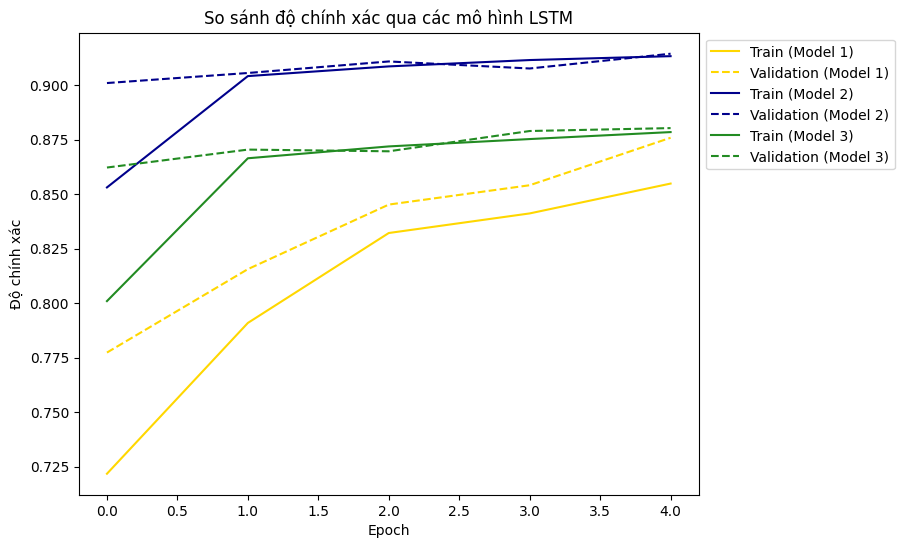

In [ ]:
import matplotlib.pyplot as plt

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(8, 6))

# Vẽ đường màu đỏ cho model 1 (train và validation)
plt.plot(model1_train_accuracies, color='gold', linestyle='-')
plt.plot(model1_valid_accuracies, color='gold', linestyle='--')

# Vẽ đường màu xanh cho model 2 (train và validation)
plt.plot(model2_train_accuracies, color='darkblue', linestyle='-')
plt.plot(model2_valid_accuracies, color='darkblue', linestyle='--')

# Vẽ đường màu xanh lá cây cho model 3 (train và validation)
plt.plot(model3_train_accuracies, color='forestgreen', linestyle='-')
plt.plot(model3_valid_accuracies, color='forestgreen', linestyle='--')

# Đặt tiêu đề của biểu đồ
plt.title('So sánh độ chính xác qua các mô hình LSTM')

# Đặt tên trục y
plt.ylabel('Độ chính xác')

# Đặt tên trục x
plt.xlabel('Epoch')

# Thêm chú thích
plt.legend(['Train (Model 1)', 'Validation (Model 1)',
            'Train (Model 2)', 'Validation (Model 2)',
            'Train (Model 3)', 'Validation (Model 3)'],
           bbox_to_anchor=(1, 1))


# Hiển thị biểu đồ
plt.show()
